# Compare different normalization strategies to obtain anomaly probabilities

Time series anomaly detectors typically compute an anomaly score to dictate how anomalous a point is. This score is in the interval $[0, +\infty[$ with a higher score implying a more anomalous observation. The `decision_function(trend_data: np.ndarray)` method in a `TimeSeriesAnomalyDetector` instances computes this score. However, the score has some problems. First, it is difficult to decide if a certain instance is anomalous based on the absolute value of the anomaly score, because sometimes a score of 5 may indicate anomaly and otherwise the same score indicates normal. Second, the anomaly scores of two different algorithms are not comparable because they have a different interpretation (e.g., a distance in KNN vs. a depth in IForest vs. angle variation in ABOD). 

to cope with these problems, the raw anomaly scores can be converted to a probability of being anomalous. In this notebook, we analyze two methods of doing so: 
1. `min_max`: the anomaly scores are normalized using min-max normalization, resulting in a linear transformation;
2. `unify`: the anomaly scores are normalized based on a Gaussian distribution, resulting in a non-linear transformation [1].

[1] Kriegel, Hans-Peter, Kröger Peer, Schubert Erich, Zimek Arthur. "Interpreting and unifying outlier scores." Proceedings of the 2011 SIAM International Conference on Data Mining. Society for Industrial and Applied Mathematics, 2011. [DOI: 10.1137/1.9781611972818.2](https://doi.org/10.1137/1.9781611972818.2)

In [1]:
from dtaianomaly.anomaly_detection import PyODAnomalyDetector, Windowing
from dtaianomaly.visualization import plot_data, plot_anomaly_scores

## Load the data

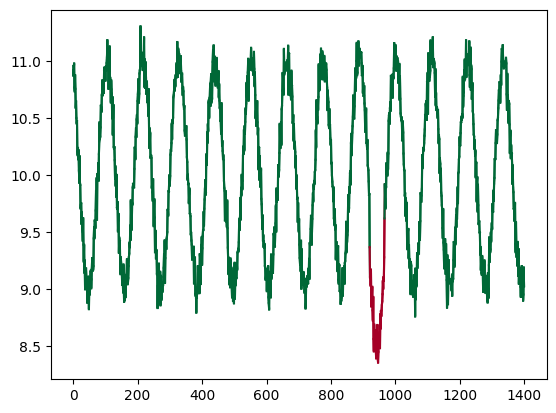

In [2]:
from dtaianomaly.data_management.DataManager import DataManager

data_manager = DataManager('../data/datasets.csv')
data_manager.select({'collection_name': 'Demo'})
dataset_index = data_manager.get(0)
trend_data_df = data_manager.load(dataset_index)
trend_data, ground_truth = data_manager.load_raw_data(dataset_index)

plot_data(trend_data_df, show_ground_truth='overlay');

## Analyze the effect of the normalization techniques

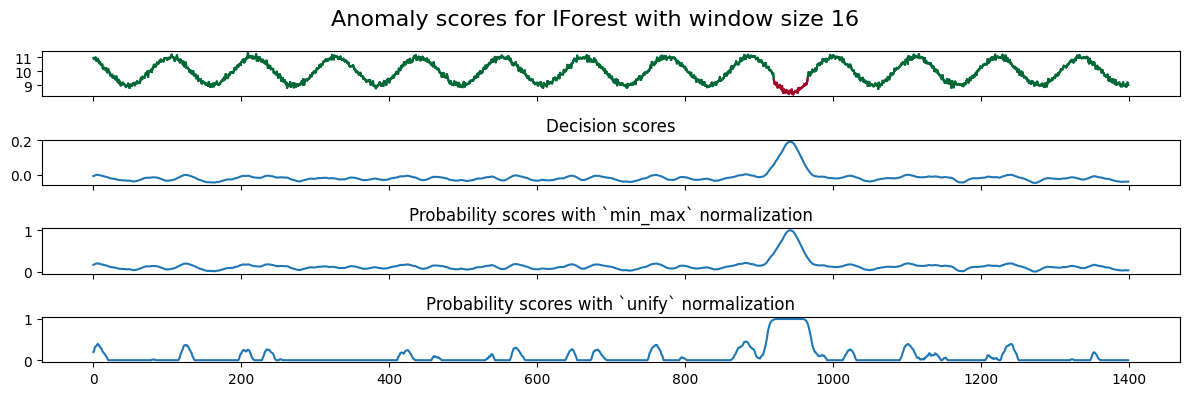

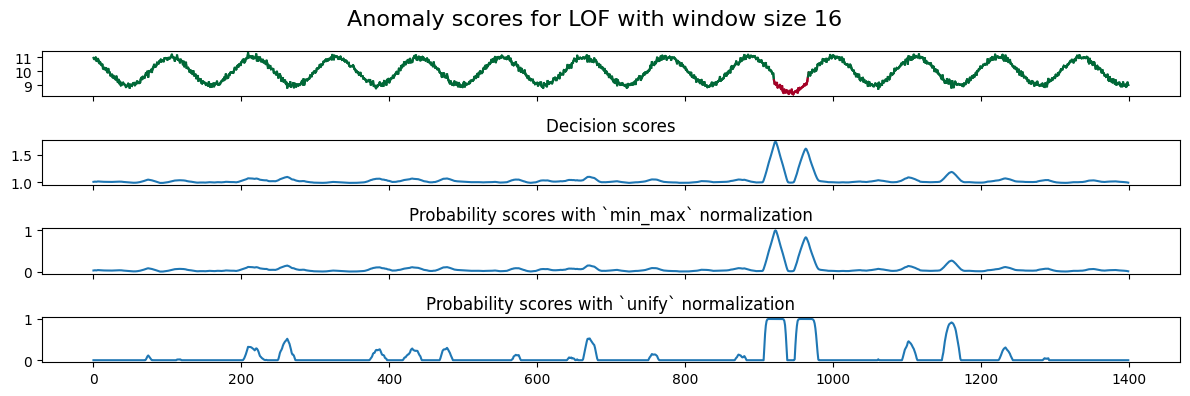

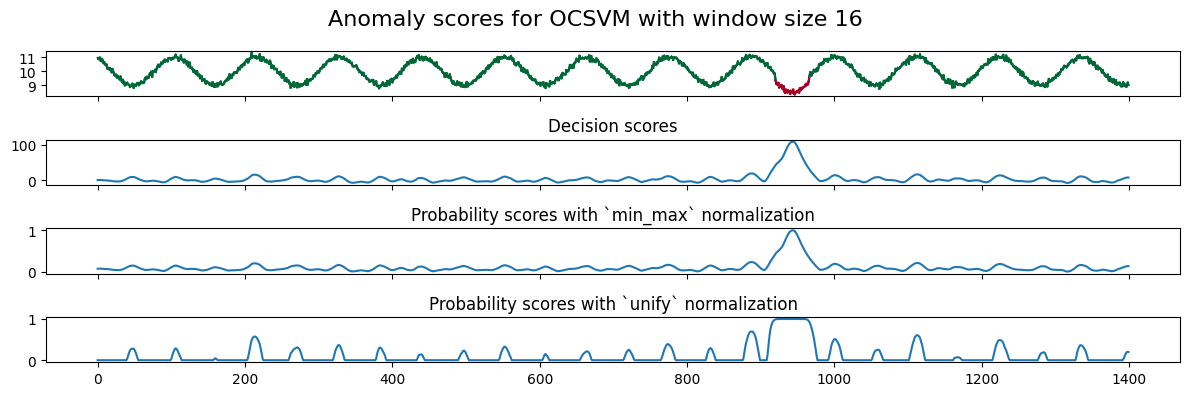

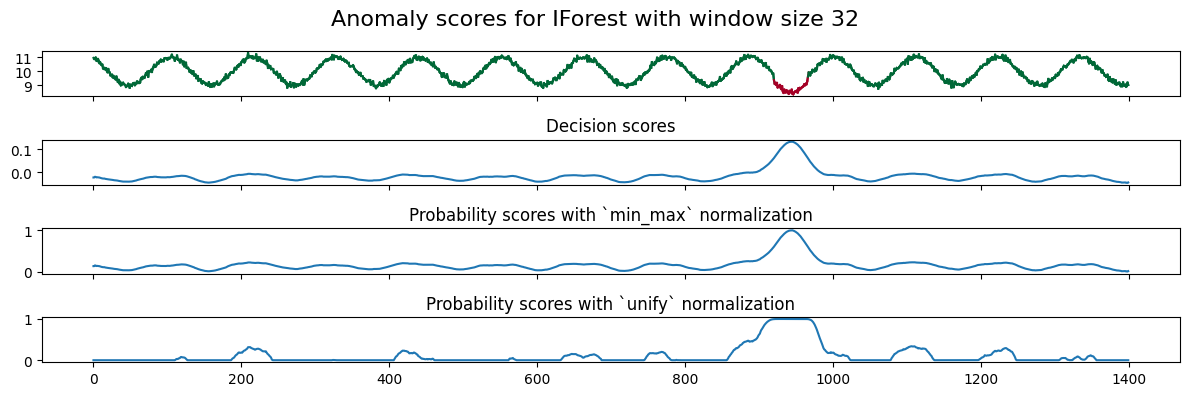

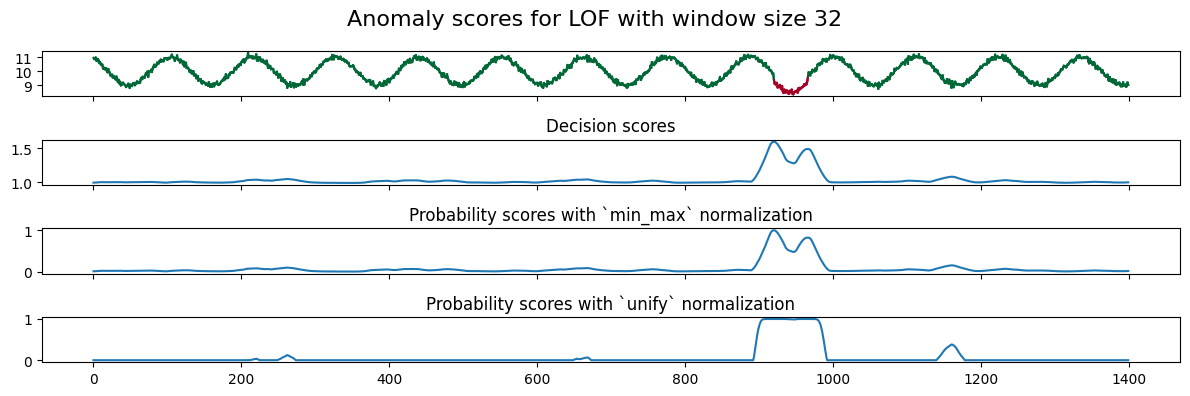

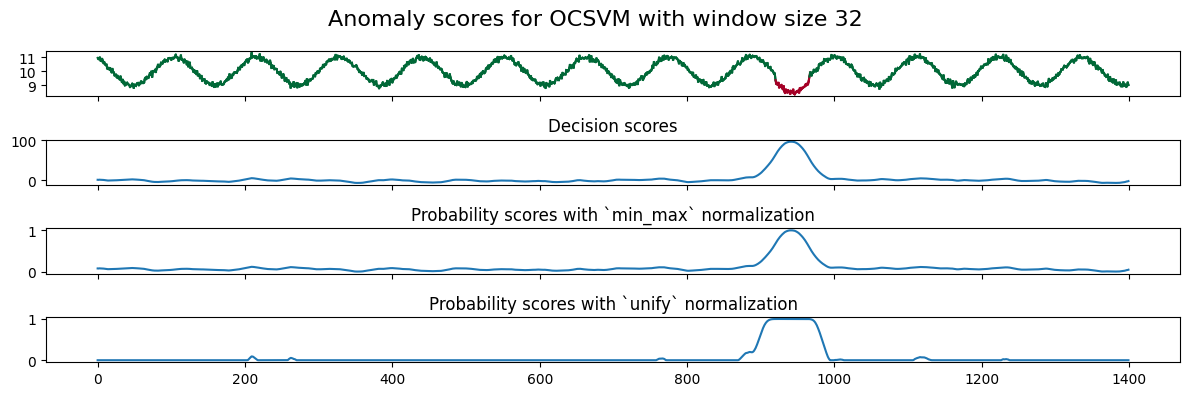

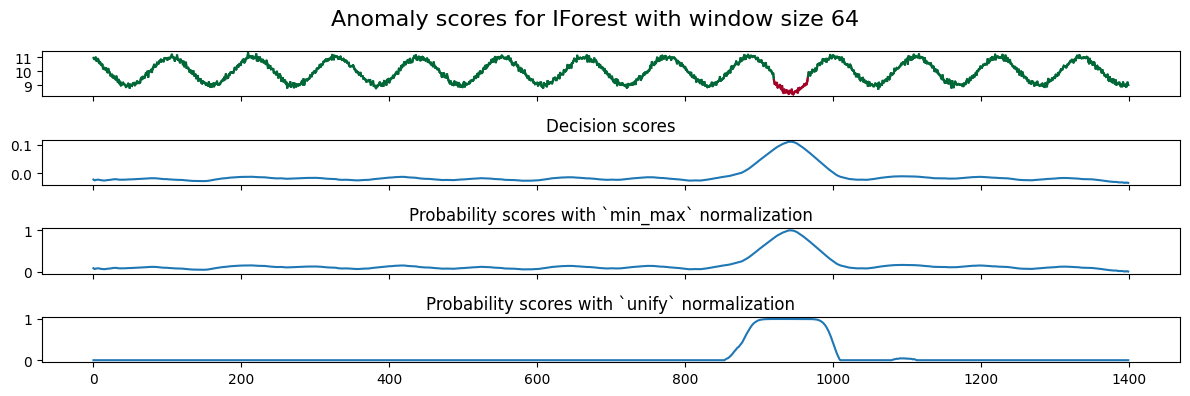

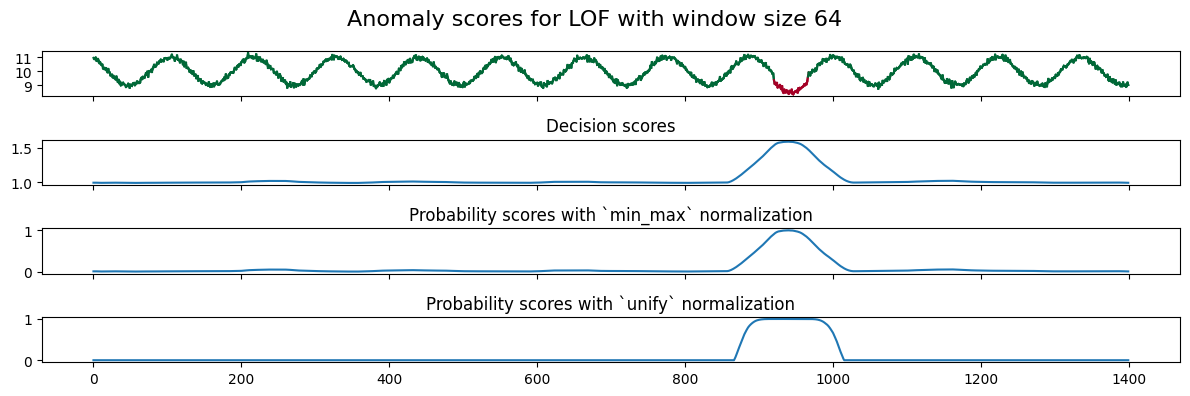

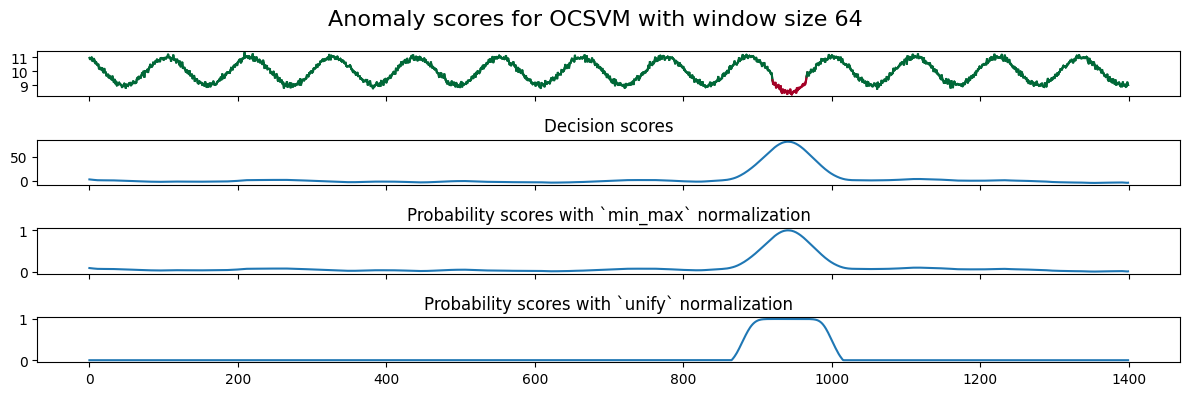

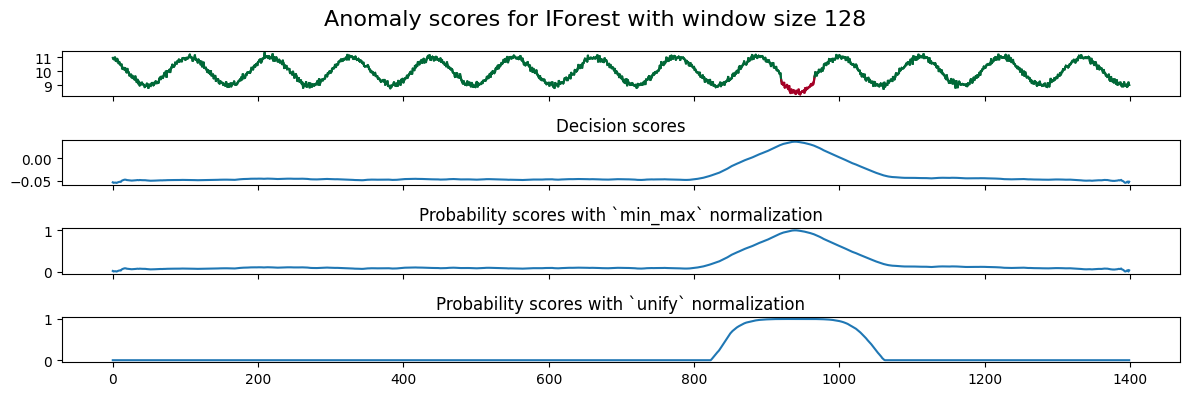

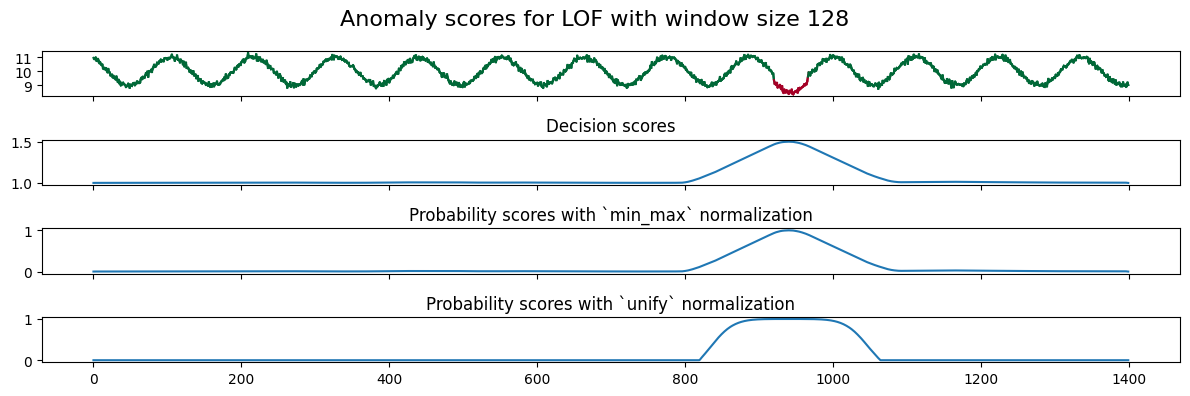

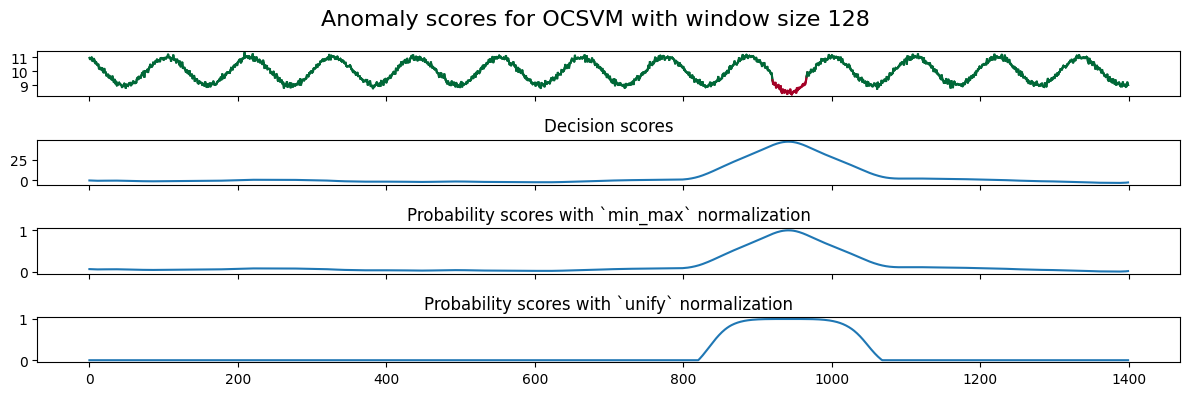

In [3]:
for window_size in [16, 32, 64, 128]:
    for anomaly_detector_name in ['IForest', 'LOF', 'OCSVM']:
        anomaly_detector = PyODAnomalyDetector(anomaly_detector_name, Windowing(window_size))
        anomaly_detector.fit(trend_data)
        fig = plot_anomaly_scores(
            trend_data=trend_data_df, 
            anomaly_scores={
                'Decision scores': anomaly_detector.decision_function(trend_data),
                'Probability scores with `min_max` normalization': anomaly_detector.predict_proba(trend_data, normalization='min_max'),
                'Probability scores with `unify` normalization': anomaly_detector.predict_proba(trend_data, normalization='unify'),
            },
            show_anomaly_scores='separate',
            show_ground_truth='overlay',
        )
        fig.set_size_inches(12, 4)
        fig.suptitle(f'Anomaly scores for {anomaly_detector_name} with window size {window_size}', fontsize=16)
        fig.tight_layout()